In [7]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
import tensorflow as tf

In [9]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
mainDIR = (os.listdir("../chest_xray"))
print(mainDIR)

['.ipynb_checkpoints', 'test', 'train', 'Untitled.ipynb', 'val']


In [11]:
train_dir = '../chest_xray/train/'
test_dir = '../chest_xray/test/'
val_dir = '../chest_xray/val/'

In [12]:
#train
os.listdir(train_dir)
train_n = train_dir + "NORMAL"
train_p = train_dir + "PNEUMONIA"

Normal Picture Title:  IM-0340-0001.jpeg
Pneumonia Picture Title:  person19_bacteria_61.jpeg


Text(0.5, 1.0, 'Pneumonia')

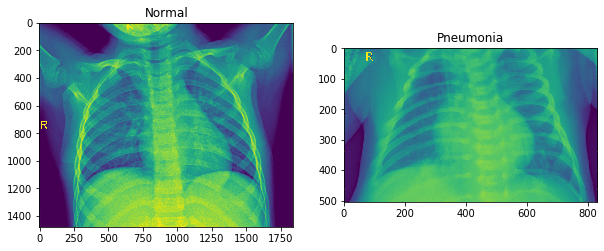

In [13]:
#normal
rand_norm = np.random.randint(0,(len(os.listdir(train_n))))
norm_pic = os.listdir(train_n)[rand_norm]
print("Normal Picture Title: ", norm_pic)
norm_pic_address = (train_n + '/' + norm_pic)

#pneumonia
rand_pne = np.random.randint(0,(len(os.listdir(train_p))))
pne_pic = os.listdir(train_p)[rand_pne]
print("Pneumonia Picture Title: ", pne_pic)
pne_pic_address = (train_p + '/' + pne_pic)

norm_load = Image.open(norm_pic_address)
pne_load = Image.open(pne_pic_address)

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(pne_load)
a2.set_title('Pneumonia')

In [14]:
#image augmentation
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.3, horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('../chest_xray/train/', target_size = (64,64), batch_size=32, class_mode='binary', shuffle=True)
validation_generator = test_datagen.flow_from_directory('../chest_xray/val/', target_size = (64,64), batch_size=32, class_mode='binary', shuffle=True)
test_set = test_datagen.flow_from_directory('../chest_xray/test/', target_size = (64,64), batch_size=32, class_mode='binary',shuffle=True)

# I will be making predictions off of the test set in one batch size
# This is useful to be able to get the confusion matrix
test_data = []
test_labels=[]

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(test_dir + cond)):
        img = plt.imread(test_dir+cond+img)
        img = cv2.resize(img, (150,150))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if cond=='/NORMAL/':
            label=0
        elif cond=='/PNEUMONIA/':
            label=1
        test_data.append(img)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
    

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
#Input Layer
inputs = Input(shape=(64, 64, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2,2))(x)

#second conv block
x = SeparableConv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

#third conv block
x = SeparableConv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

#fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate=0.2)(x)

#fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate=0.2)(x)

#FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

#output layer
output = Dense(units=1, activation='sigmoid')(x)

#creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only = True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 64, 64, 256)       1051      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 256)       590080    
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 256)       1024      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0   

In [ ]:
batch_size = 32
cnn_model = model.fit_generator(training_set, steps_per_epoch=(training_set.samples//batch_size), 
                                epochs=10, validation_data = validation_generator, 
                                validation_steps=(validation_generator.samples//batch_size), 
                                callbacks=[checkpoint, lr_reduce])


Epoch 1/10
163/163 [==============================] - 1597s 10s/step - loss: 1.2431 - accuracy: 0.7017 - val_loss: 1.1395 - val_accuracy: 0.5000
Epoch 2/10
  6/163 [>.............................] - ETA: 25:34 - loss: 0.5661 - accuracy: 0.7292

In [ ]:
history_dict = cnn_model.history
history_dict.keys()